<a href="https://colab.research.google.com/github/asia281/dnn2022/blob/main/Asia_of_hw4_rainbow_student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sample Efficient Reinforcement Learning - from DQN to (almost) Rainbow
### Author: Michal Nauman, Editor: Mateusz Olko

In this homework we will expand upon on the Deep Q-Network (DQN) algorithm [(Mnih 2014)](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf). DQN has been successfully applied to a wide range of environments and has demonstrated strong performance on many tasks. However, several challenges and limitations to the DQN that have been identified in the literature:

1. Sample complexity - DQN can require a large number of samples to learn effectively, especially in environments with high-dimensional state spaces or a large number of possible actions
2. Convergence - DQN is known to converge to the optimal solution under certain conditions, but the convergence properties of the algorithm are not well understood and it is not guaranteed to converge in all cases
3. Overestimation - DQN is known to sometimes overestimate the Q-values of certain actions, which can lead to suboptimal behavior
4. Sensitivity to hyperparameters - DQN can be sensitive to the choice of hyperparameters, such as the learning rate, the discount factor, and the exploration scheme.

Rainbow algorithm [(Hessel 2017)](https://arxiv.org/pdf/1710.02298.pdf) is a combination of several techniques for improving the performance of the DQN algorithm, which was originally proposed by DeepMind. By combining several techniques, the Rainbow algorithm is able to improve the sample efficiency, stability and  performance of the DQN algorithm. Overall, the Rainbow algorithm represents an important step forward in the development of reinforcement learning algorithms and is often used as a baseline for implementing more complex changes to the RL setup (e.g. [(Schwarzer 2021)](https://arxiv.org/pdf/2007.05929.pdf) or [(Srinivas 2020)](https://arxiv.org/pdf/2004.04136.pdf))

In this homework, you will learn to augment a simple DQN implementation with all the components of Rainbow except for distributional Q-learning. To test our implementations, we will use the Lunar Lander environment. Given resources, the environment is easily solved by a vanilla DQN implementation. But we do not have resources. What we have is a budget of:

1. 40 000 environment steps
2. 35 000 Q-network updates 

And quite inefficient exploration scheme. As such, our basic DQN implementation will not be enough to solve Lunar Landing problem within the constraints.

## Homework scenario and grading

We provide you with a basic implementation of the DQN. Your job is to expand it with the following modules:

1. Double Q-Learning - [(van Hasselt 2015)](https://arxiv.org/pdf/1509.06461.pdf) **1.5 pkt**
2. N-step learning - [(Sutton 1988)](http://incompleteideas.net/papers/sutton-88-with-erratum.pdf) **1.5 pkt**
3. Noisy linear layers - [(Fortunato et al. 2017)](https://arxiv.org/pdf/1706.10295.pdf) **1.5 pkt**
4. Dueling network architecture - [(Wang et al. 2015)](https://arxiv.org/pdf/1511.06581.pdf) **1.5 pkt**
5. Prioritized experience replay - [(Schaul et al. 2015)](https://arxiv.org/pdf/1511.05952.pdf) **1.5 pkt**
6. (Almost) Rainbow - [(Hessel 2017)](https://arxiv.org/pdf/1710.02298.pdf) **1.5 pkt**

Each module is designed to work independently (i.e. you can implement each individually with DQN). The final task of this homework is to combine all the implemented modules into (almost) Rainbow agent. You get the last point (**1 pkt**) for plotting results for all implemented parts.

We import the necessary modules:

In [1]:
!pip install gym[box2d]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 KB 23.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 78.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 52.1 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for box2d-py
  Running setup.py clean for box2d-py
Failed to build box2d-py
  Running setup.py install for box2d-py ... done
  DEPRECATION: box2d-py was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. Discussion can be found at https:

In [2]:
import os
import math
import random
import time

import gym
from google.colab import files
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim


We define a simple class for holding the hyperparameters (do not change those!)

In [3]:
# do not change!
class parse_args:
    def __init__(self):
        self.gym_id = "LunarLander-v2"
        self.capacity = 10000
        self.init_steps = 10000
        self.batch_size = 128
        self.hidden_dim = 128
        self.learning_rate = 7e-4
        self.discount = 0.99
        self.samples = 3
        self.total_timesteps = 70000
        self.target_update_freq = 50
        self.evaluate_freq = 1000
        self.evaluate_samples = 5
        self.anneal_steps = 50000
        self.epsilon_limit = 0.01
        self.cuda = True
        env = gym.make(self.gym_id)
        self.state_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.n
        self.device = torch.device("cuda" if torch.cuda.is_available() and self.cuda else "cpu")
        
args = parse_args()

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


And two helper functions: one for setting seeds, one for simple orthogonal initialization of linear layers, and one for saving and downloading training results.

In [4]:
def set_seed_everywhere(env, seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    env.reset(seed=seed)
    
def weight_init(model):
    if isinstance(model, nn.Linear):
        nn.init.orthogonal_(model.weight.data)
        model.bias.data.fill_(0.0)

def download_numpy(filename, data):
    np.save(filename, data)
    files.download(filename)

## 0. DQN

Deep Q-Network (DQN) [(Mnih 2014)](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf) is a reinforcement learning algorithm that uses a deep neural network to learn a Q-function, which is a function that estimates the expected return for taking a given action in a given state. The goal of the DQN algorithm is to learn a policy that maximizes the expected return by learning the Q-function and selecting the action with the highest estimated return in each state.

The DQN algorithm consists of two main components: a Q-network and an experience buffer. The Q-network is a deep neural network that takes in a state as input and outputs the estimated Q-values for each possible action. The experience buffer is a data structure that stores a set of experiences. The DQN algorithm works by interacting with the environment and storing the experiences in the experience buffer. The Q-network is then trained using a mini-batch of experiences uniformly sampled from the experience buffer. This process is known as experience replay and is used to decorrelate the experiences and to stabilize the learning process. The Q-network is updated using the loss function:

$$
\mathcal{L}_{\theta} = \frac{1}{B} \sum_{i=1}^{B} \bigl( \mathrm{TD}~(s_i, a_i, s^{'}_{i}) \bigr)^{2}
$$

With:

$$
\mathrm{TD}~(s_i, a_i, s^{'}_{i}) = Q_{\theta}~(s_i,a_i) - \bigl(r_{(s_i,a_i,s_{i}^{'})} + \gamma ~ \underset{a^{'}_{i} \sim \bar{Q}_{\theta}}{\mathrm{max}} ~ \bar{Q}_{\theta}~(s_{i}^{'},a_{i}^{'}) \bigr)
$$

Where $Q_{\theta}$ and $\bar{Q}_{\theta}$ denote learned and target Q-networks respectively. The target network is a copy of the Q-network that is updated less frequently, and using it to compute the target Q-values helps to stabilize the learning process and improve the performance of the DQN algorithm. Note that to increase stability of training we use Huber loss (smooth_l1_loss) instead of L2.

There are several ways to incorporate exploration into the DQN algorithm. One common method is to use an $\epsilon$-greedy exploration strategy, where the agent takes a random action with probability $\epsilon$ and takes the action with the highest estimated Q-value with probability $1 - \epsilon$. The value of $\epsilon$ is typically decreased over time, so that the agent initially explores more and then gradually shifts towards exploitation as it learns more about the environment.

Below, we implement all the components of a basic DQN. We start with the experience buffer - a data structure that stores a set of transitions, where a transition is typically represented as a tuple $(s, a, r, s', t)$, where $s$ is the state, $a$ is the action taken in state $s$, $r$ is the reward received by performing $a$ in $s$ and getting to $s'$, $s'$ is the new state observed after performing $a$ in $s$ and $t$ is the termination boolean (true if $s'$ is terminal). Experience buffers are used to store the experiences of an agent as it interacts with an environment, and are used to train a Q-function, which is a function that estimates the expected return for taking a given action in a given state. We implement **ExperienceBuffer** class using NumPy arrays and we define two methods:

1. *add* - adds transition to the buffer
2. *sample* - samples a batch of transitions from the buffer

In [5]:
class ExperienceBuffer:
    def __init__(self, args):
        self.states = np.zeros((args.capacity, args.state_dim), dtype=np.float32)
        self.actions = np.zeros((args.capacity, 1), dtype=np.int64)
        self.rewards = np.zeros((args.capacity, 1), dtype=np.float32)
        self.next_states = np.zeros((args.capacity, args.state_dim), dtype=np.float32)
        self.terminals = np.zeros((args.capacity, 1), dtype=np.int64)
        self.full = False
        self.idx = 0
        self.args = args 
        
    def add(self, state, action, reward, next_state, terminal):
        self.states[self.idx, :] = state
        self.actions[self.idx, :] = action
        self.rewards[self.idx, :] = reward
        self.next_states[self.idx, :] = next_state
        self.terminals[self.idx, :] = 1 if terminal else 0
        self.idx += 1
        if self.idx == self.args.capacity:
            self.full = True
            self.idx = 0
            
    def sample(self):
        idx = np.random.permutation(self.args.capacity)[:self.args.batch_size] if self.full else np.random.permutation(self.idx-1)[:self.args.batch_size]
        states = torch.from_numpy(self.states[idx]).to(self.args.device)
        actions = torch.from_numpy(self.actions[idx]).to(self.args.device)
        rewards = torch.from_numpy(self.rewards[idx]).to(self.args.device)
        next_states = torch.from_numpy(self.next_states[idx]).to(self.args.device)
        terminals = torch.from_numpy(self.terminals[idx]).long().to(self.args.device)
        return states, actions, rewards, next_states, terminals

**QNetwork** class is a simple nn.Module MLP. Note the output size being equal to the amount of actions in the environment.

In [6]:
class QNetwork(nn.Module):
    def __init__(self, args):
        super(QNetwork, self).__init__()
        """
        state_dim = 8, hidden_dim = 128, action_dim.= 4
        """

        self.layers = nn.Sequential(
           nn.Linear(args.state_dim, args.hidden_dim), nn.ReLU(),
            nn.Linear(args.hidden_dim, args.hidden_dim), nn.ReLU(),
            nn.Linear(args.hidden_dim, args.action_dim))
        self.apply(weight_init)
        
    def forward(self, x):
        return self.layers(x)

Finally we implement DQN agent. The class has following methods:

1. *get_action* - returns action in given state using $\epsilon$-greedy
2. *anneal* - reduces the value of $\epsilon$ dependent on the training step
3. *update* - samples a batch of transitions from the experience buffer and performs a DQN update
4. *update_target* - performs a hard update on the target Q network $\bar{Q}_{\theta}$
5. *evaluate* - performs evaluation of the agent with a greedy policy 
6. *reset* - resets the agent (used between seeds)

In [7]:
class DQN:
    def __init__(self, args):
        super(DQN, self).__init__()
        self.args = args 
        self.buffer = ExperienceBuffer(self.args)
        self.epsilon = 1
        self.q_net = QNetwork(self.args).to(self.args.device)
        self.q_target = QNetwork(self.args).to(self.args.device)
        self.q_target.load_state_dict(self.q_net.state_dict())
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=self.args.learning_rate, eps=1e-5)
                
    def get_action(self, state, exploration=True):
        with torch.no_grad():
            return np.random.randint(self.args.action_dim) if np.random.sample() < self.epsilon and exploration else torch.argmax(self.q_net(state)).item()

    def anneal(self, step):
        self.epsilon = ((self.args.epsilon_limit - 1)/self.args.anneal_steps) * step + 1 if step < self.args.anneal_steps else self.epsilon

    def update(self):
        states, actions, rewards, next_states, terminals = self.buffer.sample()
        with torch.no_grad():
            q_ns = torch.max(self.q_target(next_states), dim=1)[0].unsqueeze(1)
        q_targets = rewards + (1-terminals) * self.args.discount * q_ns
        self.optimizer.zero_grad()
        q_values = self.q_net(states).gather(1, actions)
        loss = nn.functional.smooth_l1_loss(q_values, q_targets)
        loss.backward()
        self.optimizer.step()
    
    def update_target(self):
        self.q_target.load_state_dict(self.q_net.state_dict())
        
    def evaluate(self, samples):
        with torch.no_grad():
            env_test = gym.make(self.args.gym_id)
            eval_reward = 0
            for i in range(samples):
                state = env_test.reset()
                episode_reward = 0
                while True:
                    action = self.get_action(torch.tensor(state).unsqueeze(0).to(self.args.device), False)
                    next_state, reward, terminal, _ = env_test.step(action)
                    episode_reward += reward
                    state = next_state
                    if terminal:
                        eval_reward += episode_reward/samples
                        break
        return eval_reward
    
    def reset(self):
        self.buffer = ExperienceBuffer(self.args)
        self.epsilon = 1
        self.q_net = QNetwork(self.args).to(self.args.device)
        self.q_target = QNetwork(self.args).to(self.args.device)
        self.q_target.load_state_dict(self.q_net.state_dict())
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=self.args.learning_rate, eps=1e-5)

Finally, we provide code for agent training:

In [8]:
def train_agent(args, agent):
    results = np.zeros((args.total_timesteps//args.evaluate_freq, args.samples))
    for seed in range(args.samples):
        env = gym.make(args.gym_id)
        agent.reset()
        set_seed_everywhere(env, seed)
        state = env.reset()
        for step in range(args.total_timesteps):
            if step == args.init_steps:
                start_time = time.time()
            action = agent.get_action(torch.tensor(state).unsqueeze(0).to(args.device))
            next_state, reward, terminal, _ = env.step(action)
            agent.buffer.add(state, action, reward, next_state, terminal)
            agent.anneal(step)
            state = next_state
            if step >= args.init_steps:
                agent.update()
                if (step + 1) % args.target_update_freq == 0:
                    agent.update_target()
                if (step + 1) % args.evaluate_freq == 0:
                    eval_reward = agent.evaluate(args.evaluate_samples)
                    results[step//args.evaluate_freq, seed] = eval_reward
                    print("\rStep: {} Evaluation reward: {:.2f} Samples per second: {:}".format(step, eval_reward, int((step-args.init_steps)/(time.time()-start_time))), end="")
            if terminal:
                state = env.reset()
                episode_reward = 0
    return results

In [9]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1


In [10]:
def as_tensor(data: np.ndarray, dtype=torch.float32, batch: bool = False) -> torch.Tensor:
    tensor = torch.tensor(data, dtype=dtype, device=DEVICE)
    if batch and len(tensor.shape) == 1:
        tensor = tensor.unsqueeze(dim=1)
    return tensor


In [ ]:
from pyvirtualdisplay import Display
from pathlib import Path
import imageio


def make_gif(env_id, actor = None, n_episodes: int = 1, gif_name: str = "agent.gif", dir: str = "./gifs"):
    """ 
    Create a gif of an agent interacting with an environment.
    Note: It does not always work in Google colab, and crashes from time to time.
    """
    display = Display(visible=0, size=(1400, 900))
    display.start()

    Path(dir).mkdir(parents=True, exist_ok=True)
    filename = Path(dir).joinpath(gif_name)

    images = []
    env = gym.make(env_id)
    for _ in range(n_episodes):
        obs, done = env.reset(), False
        images.append(env.render("rgb_array"))
        while not done:
            if actor:
                with torch.no_grad():
                    action = actor(as_tensor(obs)).numpy()
            else:
                action = env.action_space.sample() 
            obs, reward, done, _ = env.step(action) 
            images.append(env.render("rgb_array"))

    imageio.mimsave(filename, images, fps=29)

Note that you should not change the code above - you should be able to perform all tasks by creating new classes. We train the DQN agent with given hyperparameters and inspect the results:

In [ ]:
agent = DQN(args)
results_dqn = train_agent(args, agent)
download_numpy("results_dqn.npy", results_dqn)
results_dqn.mean(1)[10:].mean()
#results_dqn.mean(1)

Step: 69999 Evaluation reward: 131.58 Samples per second: 104

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

-0.33262922972756404

As you can see, the vanilla DQN does not yield optimal performance given the budget and exploration constraints. Below is the first module that you have to add to the DQN algorithm.

## 1. Double DQN

The loss function of vanilla DQN is defined as the average of single transition temporal difference (TD) error over $B$ transitions:

$$
\mathcal{L}_{\theta} = \frac{1}{B} \sum_{i=1}^{B} \bigl( \mathrm{TD}~(s_i, a_i, s^{'}_{i}) \bigr)^{2}
$$

With transitions $(s_i, a_i, s^{'}_{i})$ sampled uniformly from the experience buffer. The transition TD error is defined through Bellman optimality condition:

$$
\mathrm{TD}~(s_i, a_i, s^{'}_{i}) = Q_{\theta}~(s_i,a_i) - \bigl(r_{(s_i,a_i,s_{i}^{'})} + \gamma ~ \underset{a^{'}_{i} \sim \bar{Q}_{\theta}}{\mathrm{max}} ~ \bar{Q}_{\theta}~(s_{i}^{'},a_{i}^{'}) \bigr)
$$

Where $Q_{\theta}$ and $\bar{Q}_{\theta}$ denote learned and target Q-networks respectively. In the setup above $a_{i}^{'}$ is chosen via maximum operation over the output of the target Q-network for $s^{'}_{i}$. Using a single network to choose the best action and estimate its Q-value promotes overestimated values. Using such values for supervision leads in turn to general overoptimism of the Q-network and is known to sabotage the training.

In Double Deep Q-Network (DDQN) [(van Hasselt 2015)](https://arxiv.org/pdf/1509.06461.pdf) proposes using two Q-networks in the process of target estimation: one Q-network to choose the maximum valued action from (i.e. *argmax*); and the second one to estimate value of the chosen action (i.e. Q-value estimation for the *argmax* result). Authors show that in DDQN estimated Q-values are less likely to be inflated and lead to more stable learning and better policies. We can use $Q_{\theta}$ and $\bar{Q}_{\theta}$ to augment DQN into DDQN: 

$$
\mathrm{TD}~(s_i, a_i, s^{'}_{i}) = Q_{\theta}~(s_i,a_i) - \bigl(r_{(s_i,a_i,s_{i}^{'})} + \gamma ~ \bar{Q}_{\theta}~(s_{i}^{'},\underset{a^{'}_{i} \sim Q_{\theta}}{\mathrm{argmax}} ~ Q_{\theta} (s_{i}^{'}, a^{'}_{i})  \bigr)
$$

Such definition of DDQN leads to very small code changes w.r.t. vanilla DQN implementation. Although $Q_{\theta}$ and $\bar{Q}_{\theta}$ are not fully decoupled, using them leads to good performance increase without introduction of additional networks.

### Task 1.1: Implement and train DDQN 
Implement the *update* method for **DDQN** class (no other method of the base class should be changed): 

In [ ]:
class DDQN(DQN):
    def __init__(self, args):
        super(DDQN, self).__init__(args)
        
    def update(self):
        states, actions, rewards, next_states, terminals = self.buffer.sample()
        ###############

        with torch.no_grad():
            next_state_actions = self.q_net(next_states).max(1)[1]
            next_state_values = self.q_target(next_states).gather(1, next_state_actions.unsqueeze(-1))

        q_targets = rewards + (1-terminals) * self.args.discount * next_state_values
        #print(f'double: {next_state_values.shape}, {q_targets.shape}')
        ###############
        self.optimizer.zero_grad()
        q_values = self.q_net(states).gather(1, actions)
        loss = nn.functional.smooth_l1_loss(q_values, q_targets)
        loss.backward()
        self.optimizer.step()

In [ ]:
agent = DDQN(args)
results_dqn1 = train_agent(args, agent)
download_numpy("results_dqn1.npy", results_dqn1)
results_dqn1.mean(1)[-10:].mean()
#results_dqn1.mean(1)

Step: 69999 Evaluation reward: 96.01 Samples per second: 123

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

110.15146820314855

## 2. $\mathrm{TD}_{n}$ - N-step Q-value estimation

$N$-step TD ($\mathrm{TD}_{n}$) was introduced long before neural network based RL. In regular TD, we supervise the Q-network with single-step reward summed with highest Q-value of the next state. In contrast to that, $\mathrm{TD}_{n}$ accumulated rewards over $n$ steps and sums it with the highest Q-value of the state that occured after $n$ steps [(Sutton 1988)](http://incompleteideas.net/papers/sutton-88-with-erratum.pdf). Double DQN $\mathrm{TD}_{n}$ loss is defined by:

$$
\mathrm{TD}_{n}(s_i, a_i, s^{'}_{i+n}) = Q_{\theta}~(s_i,a_i) - \biggl(\sum_{k=0}^{n-1} \gamma^{k} ~ r_{(s_{i+k},a_{i+k},s_{i+k}^{'})} + \gamma^{n} \underset{a^{'}_{i+n} \sim \bar{Q}_{\theta}}{\mathrm{max}} ~ \bar{Q}_{\theta}~(s_{i+n}^{'},a_{i+n}^{'}) \biggr)
$$

Implementing $\mathrm{TD}_{n}$ requires changes to the ExperienceBuffer class. We will implement those changes using the **deque** module. This module will store $n$ of the most recent transitions, and will act as an intermediate between agent and buffers main storage. As compared to single step reward and $s_{i}^{'}$ stored by the simple ExperienceBuffer, the main storage of this upgraded buffer should store $n$ step rewards and $s_{i+n}^{'}$.

### Task 2.1 Implement NStepBuffer
Implement *get_nstep* method for **NStepBuffer** class (no other method of base class should be changed). The *get_nstep* method should process current memory and output a tuple of five:
* state for which the $\mathrm{TD}_{n}$ reward was computed,
* action chosen in that step in processed trajectory,
* $\mathrm{TD}_{n}$ reward computed using *nstep* rewards,
* state reached after *nstep* steps (possibly earlier if terminal state was encountered),
* terminal flag, that notifies wheather trajectory has reached terminal state within *nstep* steps.

In [11]:
from collections import deque

class NStepBuffer(ExperienceBuffer):
    def __init__(self, args, nstep):
        super(NStepBuffer, self).__init__(args)
        self.memories = deque(maxlen=nstep)
        self.nstep = nstep 
        
    def add(self, state, action, reward, next_state, terminal):
        terminal_ = 1 if terminal else 0 
        memory = (state, action, reward, next_state, terminal_)
        self.memories.append(memory)
        if len(self.memories) >= self.nstep:
            state, action, reward, next_state, terminal = self.get_nstep()
            self.states[self.idx, :] = state
            self.actions[self.idx, :] = action
            self.rewards[self.idx, :] = reward
            self.next_states[self.idx, :] = next_state
            self.terminals[self.idx, :] = terminal
            self.idx += 1
            if self.idx == self.args.capacity:
                self.full = True
                self.idx = 0
            
    def get_nstep(self):
        ###############
        state, action, reward, _, _ = self.memories[0]
        _, _, recent_reward, next_state, terminal = self.memories[-1]
        new_reward = reward
        for i in range(1, self.nstep):
          new_reward *= self.args.discount 
          new_reward += self.memories[i][2]
        ###############
        return state, action, new_reward, next_state, terminal

### Task 2.2: Implement and train N-step DQN 
Implement the *update* method for **NStepDQN** class (no other method of base class should be changed): 

In [ ]:
class NStepDQN(DQN):
    def __init__(self, args, nstep=3):
        super(NStepDQN, self).__init__(args)
        self.nstep = nstep
        self.buffer = NStepBuffer(args, nstep)
        
    def update(self):
        states, actions, rewards, next_states, terminals = self.buffer.sample()
        ###############
        with torch.no_grad():
            q_ns = torch.max(self.q_target(next_states), dim=1)[0].unsqueeze(1)
        gamma = self.args.discount ** self.nstep

        q_targets = rewards + (1-terminals) * gamma * q_ns
        ###############
        self.optimizer.zero_grad()
        q_values = self.q_net(states).gather(1, actions)
        loss = nn.functional.smooth_l1_loss(q_values, q_targets)
        loss.backward()
        self.optimizer.step()
        
    def reset(self):
        super().reset()
        self.buffer = NStepBuffer(self.args, self.nstep)

In [ ]:
agent = NStepDQN(args)
results_dqn2 = train_agent(args, agent)
download_numpy("results_dqn2.npy", results_dqn2)
results_dqn2.mean(1)[-10:].mean()

Step: 69999 Evaluation reward: 194.54 Samples per second: 138

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

164.96036101929093

## 3. Noisy Layer Exploration

$\epsilon$-greedy exploration is not well suited for environments that require complex sequences of actions to achieve success. $\epsilon$ value must be set manually, and finding a good value can be difficult and costly. A value that is too high will result in too much exploration and slow down learning, while a value that is too low will not allow the agent to gather enough information about the environment. Now, we will introduce a different method for exploration.

Noisy linear layer, is a type of layer that can be added to a neural network [(Fortunato et al. 2017)](https://arxiv.org/pdf/1706.10295.pdf). These layers add a learned noise to the parameters of the network, which adds stochasticity to the network output. Noisy parameters can induce complex multi-step changes in estimated Q-values and the policy. Noisy linear layers can be more effective than $\epsilon$-greedy in environments with sparse rewards or long-term dependencies, but they can also be less sample-efficient than well tuned $\epsilon$-greedy strategy in simpler settings. 

Regular linear layer has $pq + q$ parameters, where $p$ and $q$ denote number of inputs and outputs in the layer. Denoting weight matrix as $W \in \mathbb{R}^{q \times p}$, bias vector as $B \in \mathbb{R}^q$ and layer input as $X \in \mathbb{R}^p$, linear layer performs:

$$
Y = W X + B
$$

In contrast to that, noisy linear layer is defined as:

$$
Y = \bigl( \mu^W + \sigma^W \odot \epsilon^W \bigr) X + \bigl( \mu^B + \sigma^B \odot \epsilon^B \bigr)
$$

where $\mu^W + \sigma^W \odot \epsilon^W$ and $\mu^B + \sigma^B \odot \epsilon^B$ replace $W$ and $B$ in the first linear layer equation. The parameters $\mu^W \in \mathbb{R}^{q \times p}, \mu^B \in \mathbb{R}^q, \sigma^W \in \mathbb{R}^{q \times p}$ and $\sigma^B \in \mathbb{R}^q$ are learnt jointly via the single Q-network loss; $\epsilon^W \in \mathbb{R}^{q \times p}$ and $\epsilon^B \in \mathbb{R}^q$ is the random noise. In principle, the random noise can be generated following any distribution, but the authors consider two strategies:

1. **Independent Gaussian noise** - We generate each noise entry independently. As such, we perform $pq + q$ calls to the Gaussian noise generator. Simple, but can be costly for big networks

2. **Factorised Gaussian noise** - This is a more computationally efficient way that authors use in the original paper. Instead of generating $pq + q$ entries independently, we generate two noise vectors: $\epsilon^{p}, \epsilon^{B} \sim N(0, 1)$. Then, entries to $\epsilon^W$ are given by:

$$
\epsilon^{W}_{i,j} = f(\epsilon^{p}_{i}) f(\epsilon^{B}_{j}) \quad \text{with} \quad f(x) = sgn(x) \sqrt{|x|}.
$$

### Task 3.1 Implement NoisyLinear layer 
Implement the **NoisyLinear** class. The parameters of the noisy linear layer should be initialized with a correct initialization scheme (see section 3.2 in [Fortunato et al. 2017](https://arxiv.org/pdf/1706.10295.pdf)). The class should have the following methods:

1. *get_noise* - the method should generate $\epsilon^{W}$ and $\epsilon^{B}$ using the factorised Gaussian noise procedure
2. *forward* - generate noise and perform a forward pass

In [226]:
from torch.autograd import Variable

class NoisyLinear(nn.Module):
    def __init__(self, input_size, output_size, std):
        super(NoisyLinear, self).__init__()
        self.w_mu = nn.Parameter(torch.Tensor(output_size, input_size))
        sigma_init = 0.05 / math.sqrt(input_size)
        self.w_sigma = nn.Parameter(torch.Tensor(output_size, input_size).fill_(sigma_init))
        ###############
        self.b_sigma = nn.Parameter(torch.Tensor(output_size).fill_(sigma_init))
        self.b_mu = nn.Parameter(torch.Tensor(output_size))
        self.register_buffer("epsilon_input", torch.zeros(1, input_size))
        self.register_buffer("epsilon_output", torch.zeros(output_size, 1))

        torch.nn.init.uniform_(self.w_mu, -std, std)
        torch.nn.init.uniform_(self.b_mu, -std, std)

        self.f = lambda x: torch.sign(x) * torch.sqrt(torch.abs(x))
        ###############

    def get_device(self):
        return self.w_mu.device

    def get_noise(self):
        ###############
        self.epsilon_input.normal_()
        self.epsilon_output.normal_()

        eps_in = self.f(self.epsilon_input.data)
        eps_out = self.f(self.epsilon_output.data)

        b_noise = self.b_mu + self.b_sigma * eps_out.t()
        w_noise = torch.mul(eps_in, eps_out)
        ###############
        return Variable(w_noise), Variable(b_noise)

    def forward(self, x):
        ###############
        w_noise, b_noise = self.get_noise()
        return torch.nn.functional.linear(x, self.w_mu + self.w_sigma * w_noise, b_noise)
        ###############


class NoisyQNetwork(nn.Module):
    def __init__(self, args, std):
        super(NoisyQNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(args.state_dim, args.hidden_dim), nn.ReLU(),
            NoisyLinear(args.hidden_dim, args.hidden_dim, std), nn.ReLU(),
            NoisyLinear(args.hidden_dim, args.action_dim, std))
        
    def forward(self, x):
        return self.layers(x)

### Task 3.2 Train NoisyDQN with NoisyLayers 


In [32]:
class NoisyDQN(DQN):
    def __init__(self, args, std=0.2):
        super(NoisyDQN, self).__init__(args)
        self.q_net = NoisyQNetwork(args, std).to(args.device)
        self.q_target = NoisyQNetwork(args, std).to(args.device)
        self.q_target.load_state_dict(self.q_net.state_dict())
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=args.learning_rate, eps=1e-5)
        self.std = std
        
    def get_action(self, state, exploration=True):
        return torch.argmax(self.q_net(state)).item()

    def anneal(self, step):
        pass
    
    def reset(self):
        super().reset()
        self.q_net = NoisyQNetwork(self.args, self.std).to(self.args.device)
        self.q_target = NoisyQNetwork(self.args, self.std).to(self.args.device)
        self.q_target.load_state_dict(self.q_net.state_dict())
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=self.args.learning_rate, eps=1e-5)

In [227]:
agent = NoisyDQN(args)
results_dqn3 = train_agent(args, agent)
download_numpy("results_dqn3.npy", results_dqn3)
results_dqn3.mean(1)[-10:].mean()

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Step: 69999 Evaluation reward: 194.60 Samples per second: 161

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

46.73323903053323

## 4. DUELING DQN

State-action advantage under policy $\pi$ is given by:

$$
A^\pi (s, a) = Q^\pi (s, a) - V^\pi (s)
$$

Where $A^\pi (s, a)$ denotes state-action advantage, $Q^\pi (s, a)$ denotes state-action Q-value and $V^\pi (s)$ denotes state value. Advantage is a measure of how much better a particular action is than the state value. Given optimal policy it follows that $\underset{a}{\mathrm{max}}~Q^\pi (s, a) = V^\pi (s)$ and as such $A^\pi (s, a) \leq 0$ if $\pi$ is optimal. We can use advantages to redefine Q-values:

$$
Q^\pi (s, a) = V^\pi (s) + A^\pi (s, a)
$$

As such, we can use separate networks to predict $A^\pi (s, a)$ and $V^\pi (s)$ and retrieve Q-values using the equation above. This is exactly the idea behind the Dueling Q-network architecture [(Wang et al. 2015)](https://arxiv.org/pdf/1511.06581.pdf). Decoupling Q-values into values and advantages offers some optimization benefits:

1. $V^\pi (s)$ is independent of actions, as such the value network will have less parameters than a Q-network
2. $A^\pi (s, a)$ although action dependent, advantages oscillate around 0 and change slowly throughout the optimization

Intuitively, the dueling Q-network can more efficiently learn which states are valuable, even when the actions available in those states do not affect the environment in a meaningful way. This can be particularly helpful in large or complex environments where it may not be possible to learn good action values for every state-action pair. Dueling DQN architecture uses joint feature layer and two separate heads to represent advantage and value streams (look at Figure 1. in [(Wang et al. 2015)](https://arxiv.org/pdf/1511.06581.pdf)). To further smoothen the optimization, Dueling DQN Q-value is calculated with the following:

$$
Q_\theta (s, a) = V_\theta (s) + \bigl( A_\theta (s, a) - \sum_{a} \frac{A_\theta (s, a)}{N_a} \bigr),
$$

where $N_a$ is the number of possible actions.

### Task 4.1 Implement and train DuelingQNetwork (10% points)
Implement the **DuelingQNetwork** class and its *forward* method (no other method of the base class should be changed):

In [228]:
class DuelingQNetwork(nn.Module):
    def __init__(self, args):
        super(DuelingQNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(args.state_dim, args.hidden_dim), nn.ReLU(),
            nn.Linear(args.hidden_dim, args.hidden_dim), nn.ReLU(),)
        self.advantage_head = nn.Linear(args.hidden_dim, args.action_dim)
        self.value_head = nn.Linear(args.hidden_dim, 1)
        
    def forward(self, x):
        ################ 
        features = self.layers(x)
        #features = features.view(features.size(0), -1) 
        # features.shape = (1, 128)
        values = self.value_head(features)
        advantages = self.advantage_head(features)
        qvals = values + (advantages - advantages.mean())
        
        return qvals
        ################
    
class DuelingDQN(DQN):
    def __init__(self, args):
        super(DuelingDQN, self).__init__(args)
        self.q_net = DuelingQNetwork(args).to(args.device)
        self.q_target = DuelingQNetwork(args).to(args.device)
        self.q_target.load_state_dict(self.q_net.state_dict())
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=args.learning_rate, eps=1e-5)
        
    def reset(self):
        super().reset()
        self.q_net = DuelingQNetwork(self.args).to(self.args.device)
        self.q_target = DuelingQNetwork(self.args).to(self.args.device)
        self.q_target.load_state_dict(self.q_net.state_dict())
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=self.args.learning_rate, eps=1e-5)

In [229]:
agent = DuelingDQN(args)
results_dqn4 = train_agent(args, agent)
download_numpy("results_dqn4.npy", results_dqn4)
results_dqn4.mean(1)[-10:].mean()

Step: 69999 Evaluation reward: 82.43 Samples per second: 194

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

27.924688823633307

## 5. Prioritized experience replay

In regular experience replay the transitions are uniformly sampled during training and used to update the agent's learning policy. Prioritized replay [(Schaul et al. 2015)](https://arxiv.org/pdf/1511.05952.pdf) is a variant of the experience replay buffer that prioritizes transitions based on the magnitude of the TD error, which is a measure of how much the agent's estimates of the action values deviate from the actual values. Transitions with a higher TD error are more important for learning, because they represent a greater deviation from the agent's current understanding of the environment. By prioritizing transitions with a higher TD error, the agent can more effectively learn from its experiences and improve its performance.

To implement a prioritized replay buffer, we need to store not only the transitions themselves, but also the TD error for each transition. We will use a queue-like mechanism to prioritize the transitions based on their TD error, and sample transitions from the buffer using a priority-based sampling distribution. New transitions arrive with maximal priority in order to guarantee that all experience is seen at least once. This allows the agent to more effectively learn from rare or unusual transitions that might be overlooked in a standard experience replay buffer.

There are two ways to prioritize transitions in the experience replay buffer based on the TD error: greedy prioritization and stochastic prioritization. When using greedy prioritization, the transitions with the highest TD errors are replayed more frequently, which can lead to overfitting and overlooking certain transitions. To address this issue, we will use a stochastic prioritization method that balances between greedy prioritization and uniform random sampling introducing more diversity in the sampled transitions.

$$
P(i) = \frac{p_i^{\alpha} + \epsilon}{\sum_{j=1}^{D} (p_j^{\alpha} + \epsilon)}
$$

Where $p_i > 0$ denotes the priority of transition $i$ with $i, j \in D$, $D$ denotes the buffer data, $\epsilon$ is a small positive constant and the exponent $\alpha$ determines how much prioritization is used, with $\alpha = 0$ corresponding to the uniform sampling. 

The estimation of the expected value with stochastic updates relies on those updates corresponding to the same distribution as its expectation. Prioritized replay introduces bias because it changes this distribution in an uncontrolled fashion, and therefore changes the solution that the estimates will converge to (even if the policy and state distribution are fixed). To compensate for non-uniform sampling scheme, prioritized experience replay leverages one more mechanism - importance sampling. To this end, when calculating loss over the batch transition TD error is weighted with an importance weight:


$$
\mathcal{L}_{\theta} = \frac{1}{B} \sum_{i=1}^{B} \bigl( w_i * \mathrm{TD}~(s_i, a_i, s^{'}_{i}) \bigr)^{2}
$$

Where:

$$
w_i = \big( \frac{1}{D} \cdot \frac{1}{P(i)} \big)^\beta
$$

Which given $\beta = 1$ fully compensates for the non uniform sampling. We will anneal values of $\alpha$ and $\beta$ towards 1 throughout the training.

Managing priorities is often implemented via a Segment Tree. It allows us to be very efficient in sampling transitions, while creating a bit of overhead in writing new values. **You are not required to use segment tree, and no points will be subtracted for not using it. However we encourage to do it for better efficiency and shorter training time.** We provide you with the OpenAI implementation of a SegmentTree below. We recommend that you read a bit about segment trees before moving forward:

1. https://www.geeksforgeeks.org/segment-tree-set-1-sum-of-given-range/
2. https://github.com/openai/baselines/blob/master/baselines/common/segment_tree.py

**Note that the priority queue will be much slower even with good implementation. This slow down is much less visible in image-based RL, where other parts of the compute pipeline are greatly more demanding.**

In [15]:
!wget https://raw.githubusercontent.com/openai/baselines/master/baselines/common/segment_tree.py
from segment_tree import MinSegmentTree, SumSegmentTree

--2023-01-29 09:02:42--  https://raw.githubusercontent.com/openai/baselines/master/baselines/common/segment_tree.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4899 (4.8K) [text/plain]
Saving to: ‘segment_tree.py’

segment_tree.py     100%[===================>]   4.78K  --.-KB/s    in 0s      

2023-01-29 09:02:42 (67.7 MB/s) - ‘segment_tree.py’ saved [4899/4899]



### Task 5.1 Implement PrioritizedBuffer 
Implement the **PrioritizedBuffer** class and the following methods:

1. *add* - it should also manage the priorities in the trees
2. *sample* - it should samples according to priorities and return importance weights
3. *update_priorities* - it should update priorities in trees after performing DQN update
4. *get_idx* - it should sample indices according to probability ditribution
5. *calculate_weights* - it should calculate importance weights for given index

No other method of the base class should be changed. 

In [ ]:
class PrioritizedBuffer(ExperienceBuffer):    
    def __init__(self, args, alpha, beta):
        super(PrioritizedBuffer, self).__init__(args)
        tree_capacity = 1
        while tree_capacity < self.args.capacity:
            tree_capacity *= 2
        self.beta = beta 
        self.alpha = alpha
        ################
        self.sum_tree = SumSegmentTree(tree_capacity)
        self.min_tree = MinSegmentTree(tree_capacity)
        self.maximal_priority = 1.0
        self.eps = 0.00000001
        ################
        
    def add(self, state, action, reward, next_state, terminal):
        ################
        idx = self.idx
        super().add(state, action, reward, next_state, terminal)
        transition_priority = self.maximal_priority
        self.sum_tree[idx] = transition_priority ** self.alpha
        self.min_tree[idx] = transition_priority ** self.alpha
        ################
                
    def sample(self):
        ################
        idxes = self.get_idx()

        states = torch.from_numpy(self.states[idxes]).to(self.args.device)
        actions = torch.from_numpy(self.actions[idxes]).to(self.args.device)
        rewards = torch.from_numpy(self.rewards[idxes]).to(self.args.device)
        next_states = torch.from_numpy(self.next_states[idxes]).to(self.args.device)
        terminals = torch.from_numpy(self.terminals[idxes]).long().to(self.args.device)

        weights = [self.calculate_weight(idx) for idx in idxes]
        weights = torch.tensor(weights, device=self.args.device, dtype=torch.float)
        ################
        return states, actions, rewards, next_states, terminals, idxes, weights
    
    def update_priority(self, id: int, prio: float) -> None:
        if prio < 0:
          print(f'p: {prio}') 
        assert prio >= 0
        self.sum_tree[id] = prio ** self.alpha
        self.min_tree[id] = prio ** self.alpha
        self.maximal_priority = max(self.maximal_priority, prio)

    def update_priorities(self, idx, priorities):
        ################
        for id, prio in zip(idx, priorities):
            self.update_priority(id, prio)      
        ################
                
    def get_idx(self):
        ################
        idxes = []
        segment = self.sum_tree.sum() // self.args.batch_size

        for i in range(self.args.batch_size):
          # sample leaf and calculate its weight
          a = segment * i
          b = segment * (i + 1)
          upperbound = random.uniform(a, b)
          idx = self.sum_tree.find_prefixsum_idx(upperbound)
          idxes.append(idx)
            
        ################
        return idxes
    
    def calculate_weight(self, idx):
        ################
        
        # get the maximum weight in the memory
        min_probability = self.min_tree.min() / self.sum_tree.sum()  # min P(j) = min p^a / sum(p^a)
        max_weight = (min_probability * self.args.capacity + self.eps) ** -self.beta  # max wi

        p_sample = self.sum_tree[idx] / self.sum_tree.sum() # P(j) = p^a / sum(p^a)
        weight = (self.args.capacity * p_sample + self.eps) ** -self.beta  # (N * P(j)) ^ -beta
        normalized_weight = weight / max_weight  # wj = ((N * P(j)) ^ -beta) / max wi
        ################
        return normalized_weight

### Task 5.2 Train PrioritizedDQN 
Implement the **PrioritizedDQN** class and its *update* method (no other method of the base class should be changed):

In [ ]:
class PrioritizedDQN(DQN):
    def __init__(self, args, alpha=0.2, beta=0.2):
        super(PrioritizedDQN, self).__init__(args)
        self.buffer = PrioritizedBuffer(args, alpha, beta)
        self.alpha = alpha
        self.beta = beta
        
    def update(self):
        states, actions, rewards, next_states, terminals, idx, weights = self.buffer.sample()
        with torch.no_grad():
            q_ns = torch.max(self.q_target(next_states), dim=1)[0].unsqueeze(1)
        q_targets = rewards + (1-terminals) * self.args.discount * q_ns
        self.optimizer.zero_grad()
        q_values = self.q_net(states).gather(1, actions)
        td_errors = nn.functional.smooth_l1_loss(q_values, q_targets, reduction='none')
        loss = torch.mean(td_errors * weights)
        loss.backward()
        self.optimizer.step()
        priorities = td_errors.detach().squeeze().cpu().tolist()
        self.buffer.update_priorities(idx, priorities)
        
    def anneal(self, step):
        super().anneal(step)
        if step < self.args.anneal_steps:
            self.buffer.alpha = ((1 - self.alpha)/self.args.anneal_steps)*step + self.alpha
            self.buffer.beta = ((1 - self.beta)/self.args.anneal_steps)*step + self.beta
        else:
            pass

    def reset(self):
        super().reset()
        self.buffer = PrioritizedBuffer(self.args, self.alpha, self.beta)  

In [ ]:
agent = PrioritizedDQN(args)
results_dqn5 = train_agent(args, agent)
download_numpy("results_dqn5.npy", results_dqn5)
results_dqn5.mean(1)[-10:].mean()

Step: 69999 Evaluation reward: 20.79 Samples per second: 80

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

141.62777908925597

## 6. (Almost) Rainbow
The final thing we are left with is to combine all the improvements into a single agent [(Hessel 2017)](https://arxiv.org/pdf/1710.02298.pdf). To this end, you have to implement three classes:

1. **RainbowBuffer** - experience buffer that combines nstep returns and priority-based sampling
2. **RainbowQNetwork** - Q-network that uses noisy linear layers in a dueling setup
3. **RainbowDQN** - DQN that combines all of the covered techniques

![fig1](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-07-07_at_9.14.13_PM_4fMCutg.png)

### Task 6.1 Implement RainbowBuffer

In [93]:
from collections import deque 

class RainbowBuffer(NStepBuffer):
    def __init__(self, args, nstep, alpha, beta):
        super(RainbowBuffer, self).__init__(args, nstep)
        tree_capacity = 1
        while tree_capacity < self.args.capacity:
            tree_capacity *= 2
        self.sum_tree = SumSegmentTree(tree_capacity)
        self.min_tree = MinSegmentTree(tree_capacity)
        self.max_priority = 1
        self.alpha = alpha
        self.beta = beta   
        self.tree_ptr = 0
        self.eps = 0.00000001
        
    def add(self, state, action, reward, next_state, terminal):
        ################
        super().add(state, action, reward, next_state, terminal)
        
        self.sum_tree[self.tree_ptr] = self.max_priority ** self.alpha
        self.min_tree[self.tree_ptr] = self.max_priority ** self.alpha
        self.tree_ptr = (self.tree_ptr + 1) % self.args.capacity
        
        ################
                
    def sample(self):
        ################
        idxes = self.get_idx()

        states = torch.from_numpy(self.states[idxes]).to(self.args.device)
        actions = torch.from_numpy(self.actions[idxes]).to(self.args.device)
        rewards = torch.from_numpy(self.rewards[idxes]).to(self.args.device)
        next_states = torch.from_numpy(self.next_states[idxes]).to(self.args.device)
        terminals = torch.from_numpy(self.terminals[idxes]).long().to(self.args.device)

        weights = [self.calculate_weight(idx) for idx in idxes]
        weights = torch.tensor(weights, device=self.args.device, dtype=torch.float)
        ################
        return states, actions, rewards, next_states, terminals, idxes, weights
    
    def update_priority(self, id: int, prio: float) -> None:
        assert prio >= 0
        self.sum_tree[id] = prio ** self.alpha
        self.min_tree[id] = prio ** self.alpha
        self.max_priority = max(self.max_priority, prio)

    def update_priorities(self, idx, priorities):
        for id, prio in zip(idx, priorities):
            self.update_priority(id, prio)      
                
    def get_idx(self):
        idxes = []
        segment = self.sum_tree.sum() // self.args.batch_size

        for i in range(self.args.batch_size):
          # sample leaf and calculate its weight
          a = segment * i
          b = segment * (i + 1)
          upperbound = random.uniform(a, b)
          idx = self.sum_tree.find_prefixsum_idx(upperbound)
          idxes.append(idx)
            
        return idxes
    
    def calculate_weight(self, idx):        
        # get the maximum weight in the memory
        min_probability = self.min_tree.min() / self.sum_tree.sum()  # min P(j) = min p^a / sum(p^a)
        max_weight = (min_probability * self.args.capacity + self.eps) ** -self.beta  # max wi

        p_sample = self.sum_tree[idx] / self.sum_tree.sum() # P(j) = p^a / sum(p^a)
        weight = (self.args.capacity * p_sample + self.eps) ** -self.beta  # (N * P(j)) ^ -beta
        normalized_weight = weight / max_weight  # wj = ((N * P(j)) ^ -beta) / max wi
        return normalized_weight

### Task 6.2 Implement RainbowQNetwork class 

In [232]:
class RainbowQNetwork(nn.Module):
    def __init__(self, args, std):
        super(RainbowQNetwork, self).__init__()
        ################
        self.layers = nn.Sequential(
            nn.Linear(args.state_dim, args.hidden_dim), nn.ReLU(),
            NoisyLinear(args.hidden_dim, args.hidden_dim, std), nn.ReLU())
        
        self.value_head = NoisyLinear(args.hidden_dim, 1, std)
        self.advantage_head = NoisyLinear(args.hidden_dim, args.action_dim, std)
        
        ################
        
    def forward(self, x):
        ################ 
        features = self.layers(x)
        # features.shape = (1, 128)
        values = self.value_head(features)
        advantages = self.advantage_head(features)
        qvals = values + (advantages - advantages.mean())
        
        return qvals
        ################

### Task 6.2 Implement and train RainbowDQN agent 

In [233]:
class RainbowDQN(DQN):
    def __init__(self, args, nstep=3, std=0.2, alpha=0.2, beta=0.2):
        super(RainbowDQN, self).__init__(args)
        self.buffer = RainbowBuffer(args, nstep, alpha, beta)
        self.alpha = alpha
        self.beta = beta
        self.nstep = nstep 
        self.q_net = RainbowQNetwork(args, std).to(args.device)
        self.q_target = RainbowQNetwork(args, std).to(args.device)
        self.q_target.load_state_dict(self.q_net.state_dict())
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=args.learning_rate, eps=1e-5)
        self.std = std
        
    def update(self):
        ################
        states, actions, rewards, next_states, terminals, idx, weights = self.buffer.sample()
        with torch.no_grad():
            #q_ns = torch.max(self.q_target(next_states), dim=1)[0].unsqueeze(1)
            next_state_actions = self.q_net(next_states).max(1)[1]
            q_ns = self.q_target(next_states).gather(1, next_state_actions.unsqueeze(-1))

        q_targets = rewards + (1-terminals) * q_ns * (self.args.discount ** self.nstep)
        self.optimizer.zero_grad()
        q_values = self.q_net(states).gather(1, actions)
        td_errors = nn.functional.smooth_l1_loss(q_values, q_targets, reduction='none')
        loss = torch.mean(td_errors * weights)
        loss.backward()
        self.optimizer.step()
        priorities = td_errors.detach().squeeze().cpu().tolist()
        self.buffer.update_priorities(idx, priorities)
        ################
        
    def anneal(self, step):
        if step < self.args.anneal_steps and step > self.args.init_steps:
            self.buffer.alpha = ((1 - self.alpha)/self.args.anneal_steps)*step + self.alpha
            self.buffer.beta = ((1 - self.beta)/self.args.anneal_steps)*step + self.beta
        else:
            pass

    def get_action(self, state, exploration=True):
        return torch.argmax(self.q_net(state)).item()
    
    def reset(self):
        self.buffer = RainbowBuffer(self.args, self.nstep, self.alpha, self.beta) 
        self.q_net = RainbowQNetwork(self.args, self.std).to(self.args.device)
        self.q_target = RainbowQNetwork(self.args, self.std).to(self.args.device)
        self.q_target.load_state_dict(self.q_net.state_dict())
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=self.args.learning_rate, eps=1e-5)

In [ ]:
agent = RainbowDQN(args)
results_dqn6 = train_agent(args, agent)
download_numpy("results_dqn6.npy", results_dqn6)
results_dqn6.mean(1)[-10:].mean()

Step: 13999 Evaluation reward: 4.92 Samples per second: 100

# Task 7 Plot collected results
Plot evaluation performance with respect to number of frames for all versions of DQN (including raw one). Draw 90% confidence intervals for each line (see seaborn.lineplot).

In [35]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
def plot_lists(res_list, step_range):
  for res in res_list:
    data_to_plot = pd.DataFrame({"Step":step_range, "Evaluation reward":res})
    sns.lineplot(x = "Step", y = "Evaluation reward", data=data_to_plot, err_style="bars", palette = "Set1")
plt.show()

In [222]:
def plot_list(res, step_range, no_exp):
  plt.figure(figsize=(15, 8))
  plt.grid()
  plt.title(f"Evaluation reward for the experiment {no_exp}")
  data_to_plot = pd.DataFrame({
    'Steps (in k)': step_range, 
    '1': res[:, 0],
    '2': res[:, 1],
    '3': res[:, 2]})
  data_melt = pd.melt(data_to_plot, ['Steps (in k)'], value_name='Evaluation reward')

  _mean_5 = res
  for i in step_range[1:]:
    first = max(0, i - 5)
    _mean_5[i, 0] = np.mean(res[first:i, 0])
    _mean_5[i, 1] = np.mean(res[first:i, 1])
    _mean_5[i, 2] = np.mean(res[first:i, 2])

  mean_to_plot = pd.DataFrame({
    "Steps (in k)": step_range, 
    "1": _mean_5[:, 0],
    "2": _mean_5[:, 1],
    "3": _mean_5[:, 2],})
  
  mean_melt = pd.melt(mean_to_plot, ['Steps (in k)'], value_name='Evaluation reward')

  sns.lineplot(x = 'Steps (in k)', y = 'Evaluation reward', data=data_melt, ci=90, palette = "Set1", markers=True, dashes=False)
  #sns.lineplot(x = "Steps (in k)", y = "Evaluation reward", data=mean_melt,  palette = "Set2")
  plt.show()

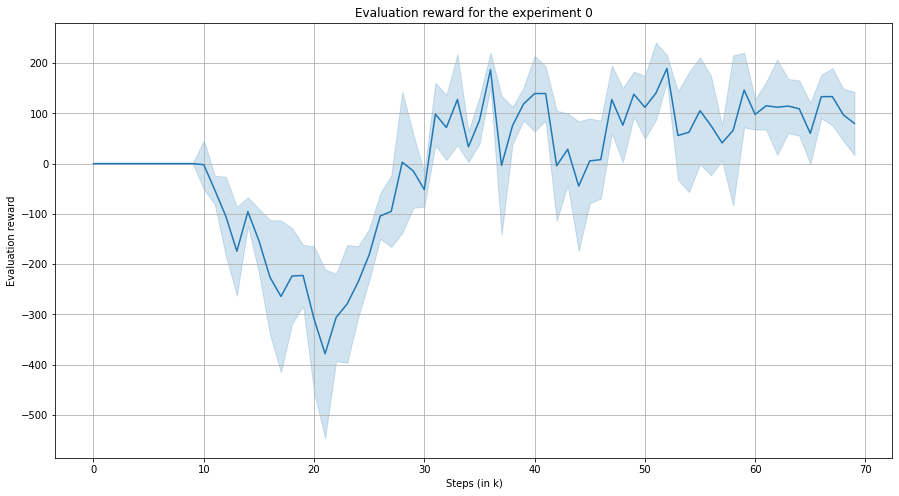

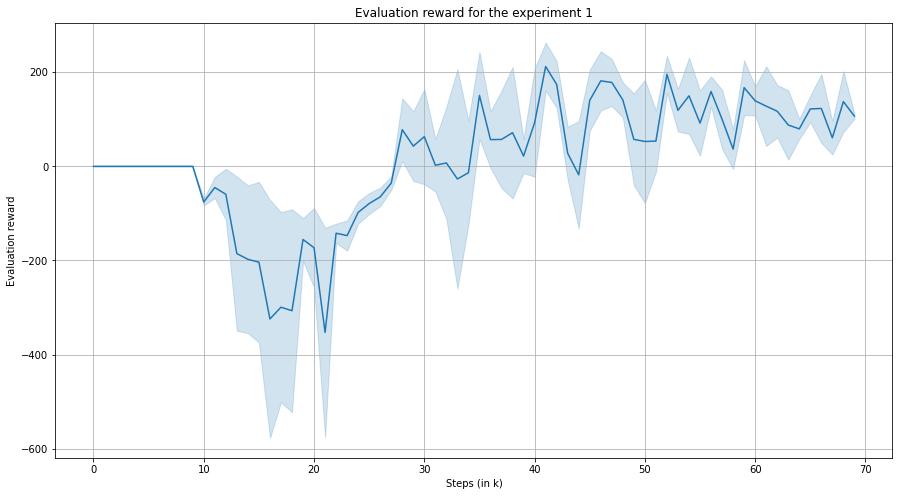

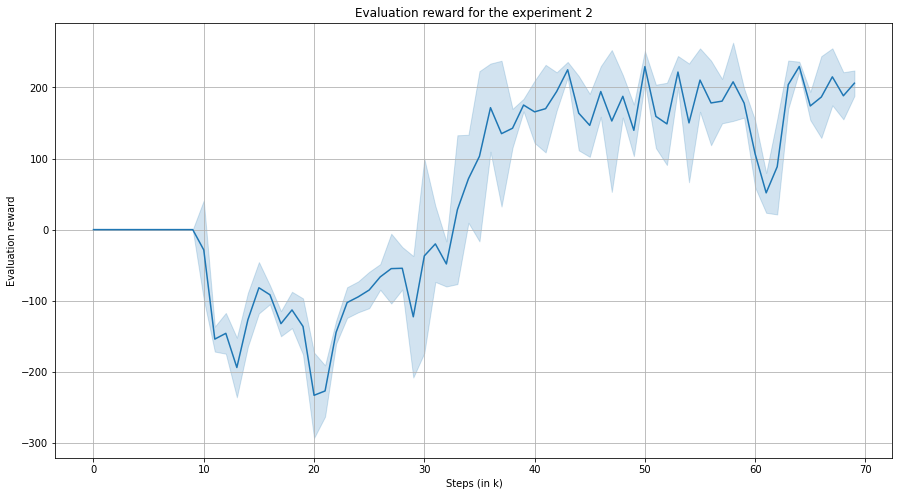

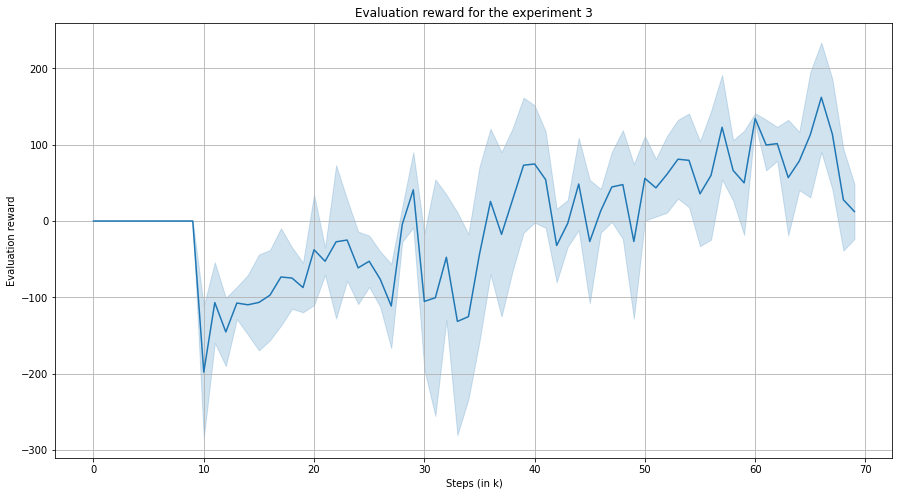

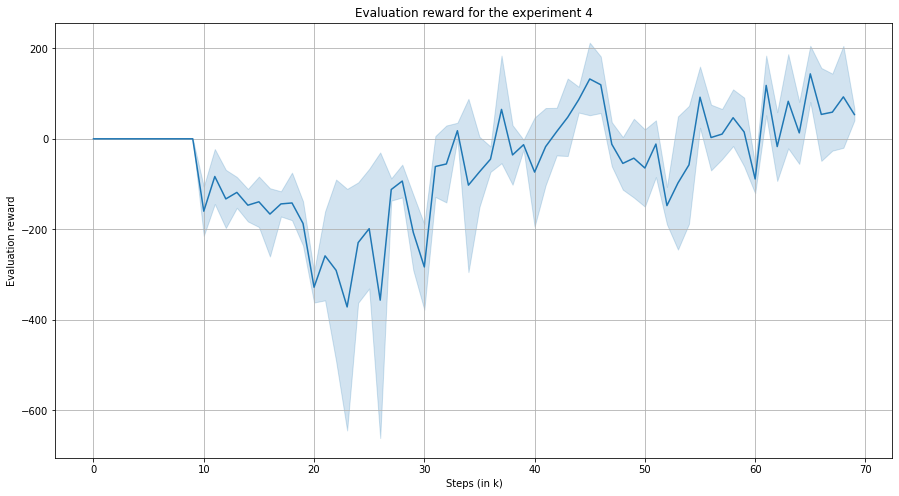

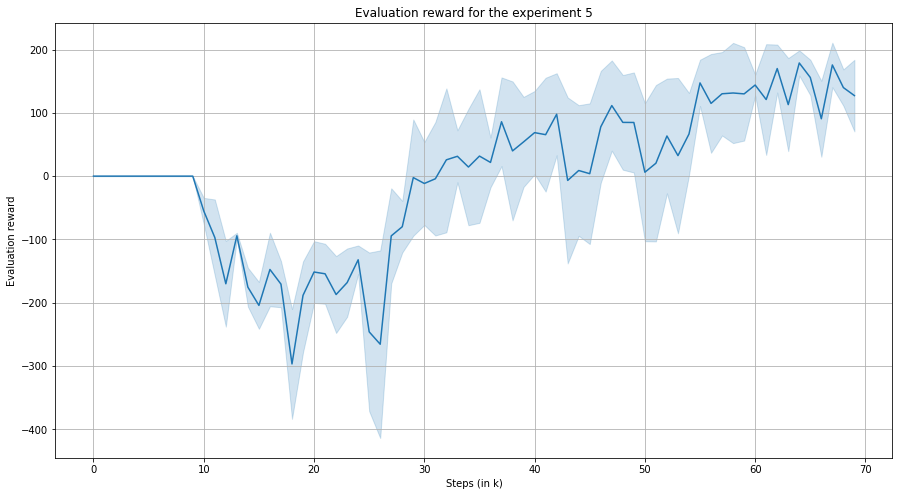

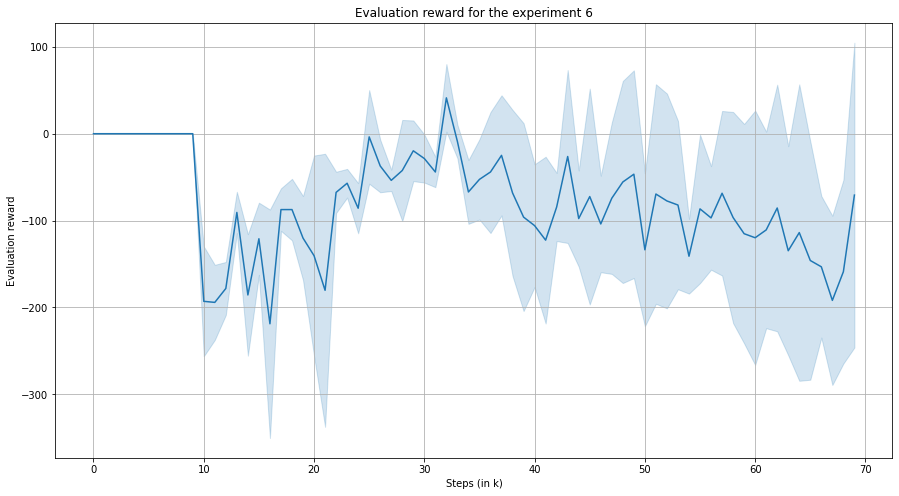

In [225]:
import numpy as np
res = [np.load("results_dqn.npy")]
rang = range(len(res[0]))
for i in range(1, 7):
  name = f'results_dqn{i}.npy'
  res.append(np.load(name))

for i in range(7):
  plot_list(res[i], rang, i)